In [3]:
import rasterio
from rasterio import mask
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import os
from skimage import exposure
from shapely.geometry import box,Polygon
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

import svdclustering

# Stacking the raster bands

In [2]:
raster,raster_arr=svdclustering.stackingfiles(path_to_folder='EO1H1480472016328110PZ_1GST/EO1H1480472016328110PZ',stacking_filename='stacked_raster.tif')

# Display the raster

Text(0.5, 1.0, 'Original image')

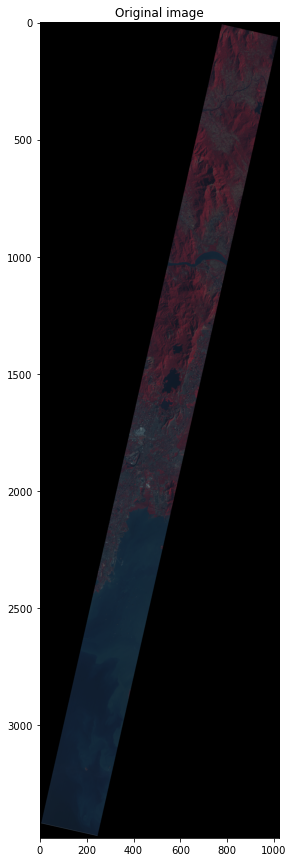

In [4]:
# plot the raster image
rasterimage=np.dstack((raster_arr[39,:,:],raster_arr[31,:,:],raster_arr[23,:,:]))
#rasterimage = exposure.equalize_hist(rasterimage)
fig = plt.figure(figsize = (15,15))
plt.imshow(rasterimage/5096)
plt.title('Original image')

# Clipping the raster file.

In [5]:
b = box(272661.214,2082713.673999623,275088.833980402,2099838.753)

In [6]:
poly=[b]

In [7]:
clipped_array=svdclustering.clippingRasterfile(input_raster='stacked_raster.tif',output_clipped_filename='clipped_raster_waterregion.tiff',polygonarray=poly)

Text(0.5, 1.0, 'raster subset')

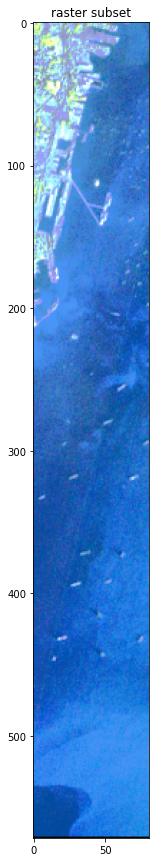

In [58]:

# plot the raster image
rasterimage=np.dstack((clipped_array[39,:,:],clipped_array[31,:,:],clipped_array[23,:,:]))
fig = plt.figure(figsize = (15,15))
rasterimage = exposure.equalize_hist(rasterimage)
plt.imshow(rasterimage)
plt.title('raster subset')

#  Dimensionality reduction using SVD and clustering using Kmeans

In [9]:
#removing unwanted bands
selectedband_indicies=np.concatenate((np.arange(8,58, 1),np.arange(77, 225, 1)),axis=0)
clipped_array=clipped_array[selectedband_indicies,:,:]

In [10]:
svd_output,labeloutput=svdclustering.SVDTruncated_kmeans(input_array=clipped_array,components_count=10,clusterCount=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, ' SVD on subset')

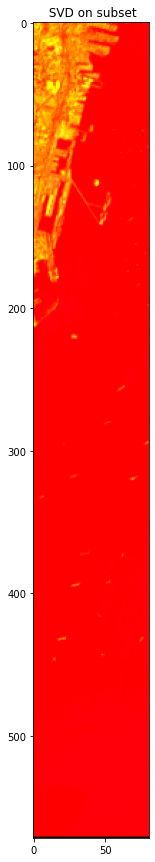

In [11]:
raster_show=np.dstack((svd_output[:,:,0],svd_output[:,:,1],svd_output[:,:,2]))
fig = plt.figure(figsize = (15,15))
plt.imshow(raster_show/5816)
plt.title(' SVD on subset')

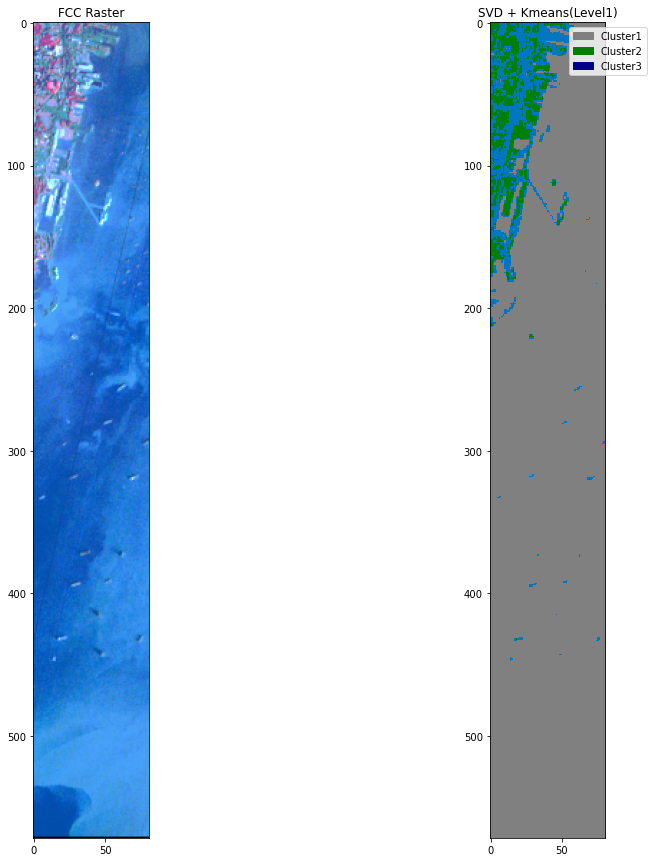

In [12]:
svdclustering.visualize_image(labeloutput,rasterimage,"FCC Raster","SVD + Kmeans(Level1)")

In [13]:
#class wise pixel count

In [14]:
classcount=3
for i in range(classcount):
    class1_pixels=np.argwhere(labeloutput==i)
    class_count=len(class1_pixels)
    print("No of pixels for cluster "+str(i+1)+" is "+str(class_count))

No of pixels for cluster 1 is 40816
No of pixels for cluster 2 is 2309
No of pixels for cluster 3 is 3207


# Second level clustering (Cluster 1)

In [19]:
labeloutput_secondlevel=svdclustering.SVDTruncated_level2_kmeans(input_array=clipped_array,components_count=10,cluster=0,labels=labeloutput,clusterCount=3)

In [21]:
#labeloutput_secondlevel[labeloutput_secondlevel==2]=1
labeloutput_secondlevel[labeloutput_secondlevel==3]=2

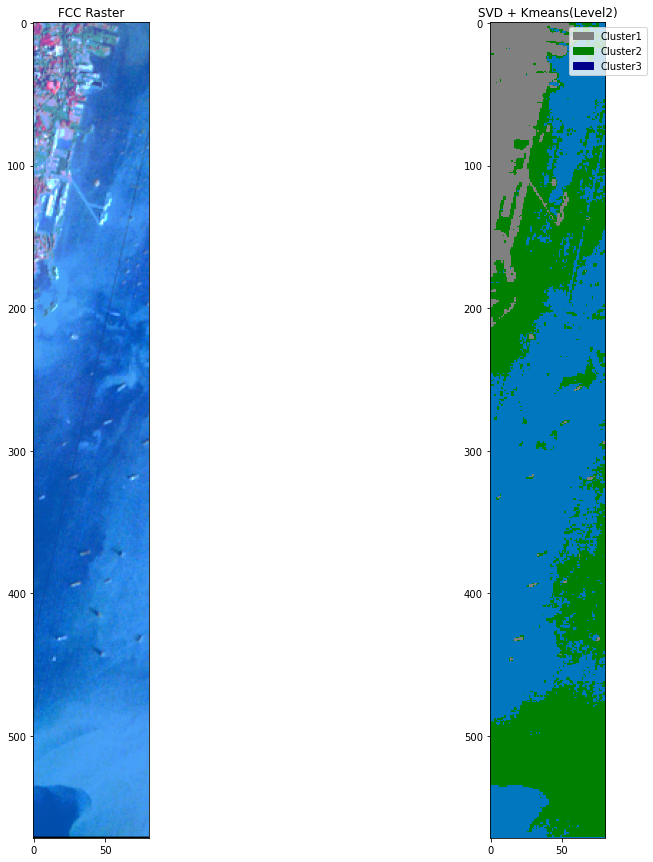

In [22]:
svdclustering.visualize_image(labeloutput_secondlevel,rasterimage,"FCC Raster","SVD + Kmeans(Level2)")

In [23]:
classcount=3
for i in range(1,classcount):
    class1_pixels=np.argwhere(labeloutput_secondlevel==i)
    class_count=len(class1_pixels)
    print("No of pixels for cluster "+str(i+1)+" is "+str(class_count))

No of pixels for cluster 2 is 17383
No of pixels for cluster 3 is 23433


# Cumulative Results and Analysis

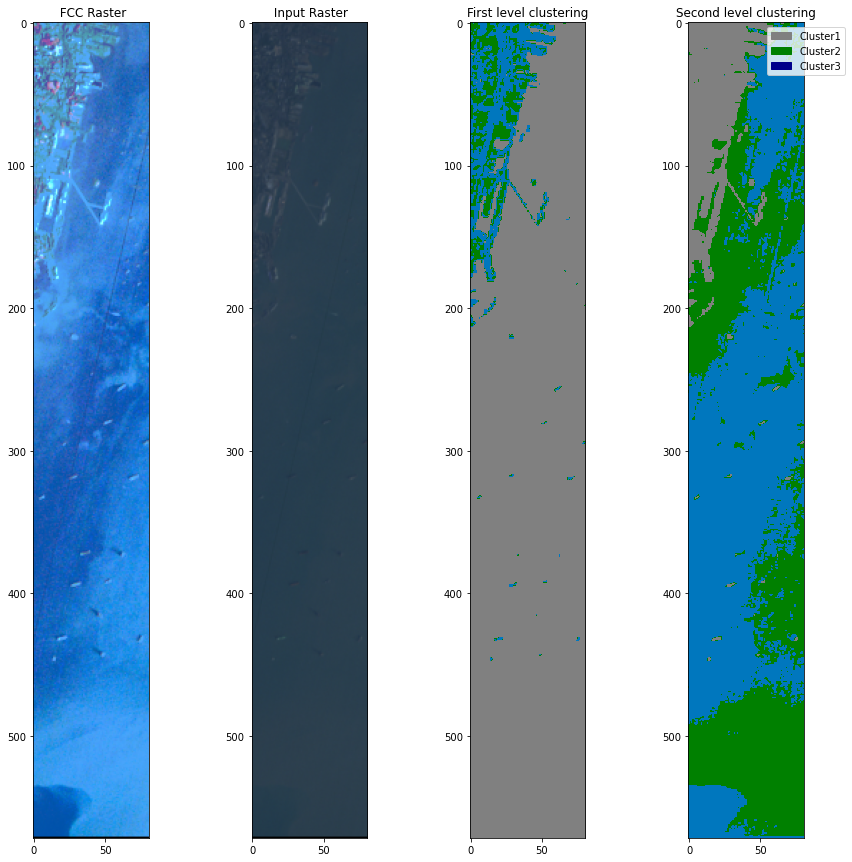

In [61]:
fig = plt.figure(figsize = (15,15))
columns = 4
rows = 1
rasterimage=np.dstack((clipped_array[32,:,:],clipped_array[25,:,:],clipped_array[16,:,:]))
rasterimage = exposure.equalize_hist(rasterimage)
fig.add_subplot(rows, columns, 1)
plt.imshow(rasterimage)
plt.title(' FCC Raster')
raster_image=np.dstack((clipped_array[22,:,:],clipped_array[13,:,:],clipped_array[5,:,:]))
fig.add_subplot(rows, columns, 2)
plt.imshow(raster_image/5096)
plt.title(' Input Raster')
level1_labelimage=labeloutput
fig.add_subplot(rows, columns, 3)
plt.imshow(level1_labelimage,cmap=svdclustering.CMAP(level1_labelimage))
plt.title('First level clustering')
level2_labelimage=labeloutput_secondlevel
fig.add_subplot(rows, columns, 4)
plt.imshow(level2_labelimage,cmap=svdclustering.CMAP(level2_labelimage))
plt.title('Second level clustering')
gray_patch = mpatches.Patch(color='Gray', label='Cluster1')
green_patch = mpatches.Patch(color='Green', label='Cluster2')
blue_patch = mpatches.Patch(color='Darkblue', label='Cluster3')
red_patch = mpatches.Patch(color='Red', label='Cluster4')
yellow_patch = mpatches.Patch(color='Yellow', label='Cluster5')
colorlist=[gray_patch,green_patch,blue_patch,red_patch,yellow_patch]
plt.legend(loc='upper right',handles=colorlist[0:3],bbox_to_anchor=(1.4, 1))
plt.show()

# Using Autoencoder for feature reduction and Kmeans for clustering

In [25]:
import autoencoder
# reshaping the data from (bands,rows,columns) to (rows, columns, bands)
row, col, bands = int(clipped_array.shape[1]), int(clipped_array.shape[2]),int(clipped_array.shape[0])
input_data=np.ndarray(shape=(row,col,bands))
for j in range(bands):
    input_data[:,:,j]=clipped_array[j,:,:]
    #reshape row* columns *bands to 1d*bands
reshape_inputdata=input_data.reshape(input_data.shape[0]*input_data.shape[1],input_data.shape[2])
reshape_inputdata_tofloat = (reshape_inputdata/ 5816.0).astype('float32') 

Using TensorFlow backend.
C:\Users\Geokno\Anaconda3\envs\newaswork\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Geokno\Anaconda3\envs\newaswork\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Geokno\Anaconda3\envs\newaswork\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Geokno\Anaconda3\envs\n

In [26]:
# shuffling the data
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)
suffled_inputdata=shuffle_along_axis(reshape_inputdata_tofloat, axis=0)

In [27]:
traintest_splitcount=int(0.75*suffled_inputdata.shape[0])

In [34]:
import autoencoder
# dimensionality reduction using autoencoders
autoencoderlevel1,encoder=autoencoder.autoencoder_dimensionaltyReduction(suffled_inputdata.shape[1])
# compiling and fitting
autoencoderlevel1.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoderlevel1.fit(suffled_inputdata[0:traintest_splitcount], suffled_inputdata[0:traintest_splitcount],
                epochs=10,
                batch_size=1000,
                shuffle=True,
                validation_data=(suffled_inputdata[traintest_splitcount:], suffled_inputdata[traintest_splitcount:]))
# encoder outputs -- reduced features
encoded_outputs = encoder.predict(reshape_inputdata_tofloat)

Train on 34749 samples, validate on 11583 samples
Epoch 1/10
34749/34749 [==============================] - 1s 32us/step - loss: 0.6722 - val_loss: 0.6089
Epoch 2/10
34749/34749 [==============================] - 1s 20us/step - loss: 0.2727 - val_loss: 0.1386
Epoch 3/10
34749/34749 [==============================] - 1s 19us/step - loss: 0.1362 - val_loss: 0.1351
Epoch 4/10
34749/34749 [==============================] - 1s 17us/step - loss: 0.1347 - val_loss: 0.1344
Epoch 5/10
34749/34749 [==============================] - 1s 27us/step - loss: 0.1343 - val_loss: 0.1343
Epoch 6/10
34749/34749 [==============================] - 1s 21us/step - loss: 0.1342 - val_loss: 0.1342
Epoch 7/10
34749/34749 [==============================] - 1s 22us/step - loss: 0.1341 - val_loss: 0.1342
Epoch 8/10
34749/34749 [==============================] - 1s 20us/step - loss: 0.1341 - val_loss: 0.1341
Epoch 9/10
34749/34749 [==============================] - 1s 20us/step - loss: 0.1341 - val_loss: 0.1341
Epoch

In [38]:
# clustering the reduced features
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(encoded_outputs)
labels_autoencoder=kmeans.labels_

In [40]:
#labels_autoencoder[labels_autoencoder==2]=1
labels_autoencoder[labels_autoencoder==3]=0

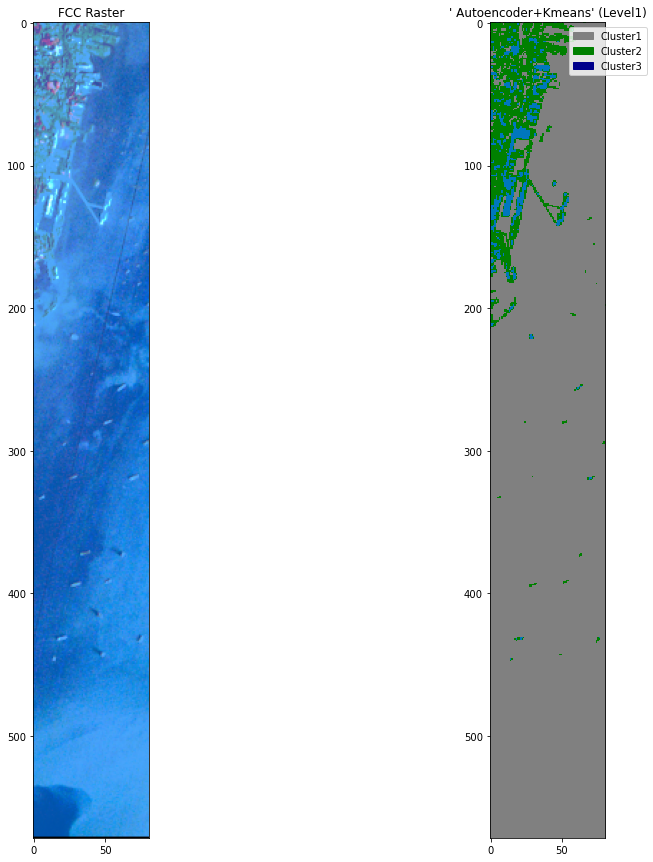

In [41]:
labels_autoencoder_output=labels_autoencoder.reshape(int(clipped_array.shape[1]), int(clipped_array.shape[2]),)
svdclustering.visualize_image(labels_autoencoder_output,rasterimage,"FCC Raster","' Autoencoder+Kmeans' (Level1)")

In [42]:
classcount=3
for i in range(classcount):
    class1_pixels=np.argwhere(labels_autoencoder_output==i)
    class_count=len(class1_pixels)
    print("No of pixels for cluster "+str(i+1)+" is "+str(class_count))

No of pixels for cluster 1 is 41152
No of pixels for cluster 2 is 3945
No of pixels for cluster 3 is 1235


# Second level clustering using Autoencoder and Kmeans

In [43]:
class_addresses=np.argwhere(labels_autoencoder==0)
class_pixels=[]
for i in class_addresses:
    class_pixels.append(reshape_inputdata_tofloat[i[0]])
class_pixels=np.array(class_pixels)

In [44]:
traintest_splitcount=int(0.75*class_pixels.shape[0])

In [45]:
import autoencoder# dimensionality reduction using autoencoders

autoencoder_level2,encoder_level2=autoencoder.autoencoder_dimensionaltyReduction(class_pixels.shape[1])
# compiling and fitting
autoencoder_level2.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder_level2.fit(class_pixels[0:traintest_splitcount], class_pixels[0:traintest_splitcount],
                epochs=10,
                batch_size=1000,
                shuffle=True,
                validation_data=(class_pixels[traintest_splitcount:], class_pixels[traintest_splitcount:]))
# encoder outputs -- reduced features
autoencoder_level2 = encoder.predict(class_pixels)

Train on 30864 samples, validate on 10288 samples
Epoch 1/10
30864/30864 [==============================] - 1s 41us/step - loss: 0.6760 - val_loss: 0.6401
Epoch 2/10
30864/30864 [==============================] - 1s 23us/step - loss: 0.3562 - val_loss: 0.1300
Epoch 3/10
30864/30864 [==============================] - 1s 20us/step - loss: 0.1261 - val_loss: 0.1216
Epoch 4/10
30864/30864 [==============================] - 1s 20us/step - loss: 0.1232 - val_loss: 0.1208
Epoch 5/10
30864/30864 [==============================] - 1s 20us/step - loss: 0.1228 - val_loss: 0.1206
Epoch 6/10
30864/30864 [==============================] - 1s 20us/step - loss: 0.1226 - val_loss: 0.1205
Epoch 7/10
30864/30864 [==============================] - 1s 20us/step - loss: 0.1225 - val_loss: 0.1204
Epoch 8/10
30864/30864 [==============================] - 1s 20us/step - loss: 0.1225 - val_loss: 0.1204
Epoch 9/10
30864/30864 [==============================] - 1s 20us/step - loss: 0.1225 - val_loss: 0.1204
Epoch

In [64]:
#reshapeimage1 = reshapeimage.astype('float32') / 5816.0

In [46]:
encoded_outputs_secondlevel = encoder_level2.predict(class_pixels)
kmeans = KMeans(n_clusters=3, random_state=0).fit(encoded_outputs_secondlevel)
labels_autoencoder_2ndlevel=kmeans.labels_
secondlevel_labeloutputs=np.zeros((int(clipped_array.shape[1])*int(clipped_array.shape[2])))
j=0;
for i in class_addresses:
    secondlevel_labeloutputs[i[0]]=labels_autoencoder_2ndlevel[j]+1
    j=j+1;
outputs_level2_autoencoder=secondlevel_labeloutputs.reshape(int(clipped_array.shape[1]),int(clipped_array.shape[2]),)

In [48]:
#outputs_level2_autoencoder[outputs_level2_autoencoder==2]=1
outputs_level2_autoencoder[outputs_level2_autoencoder==3]=2

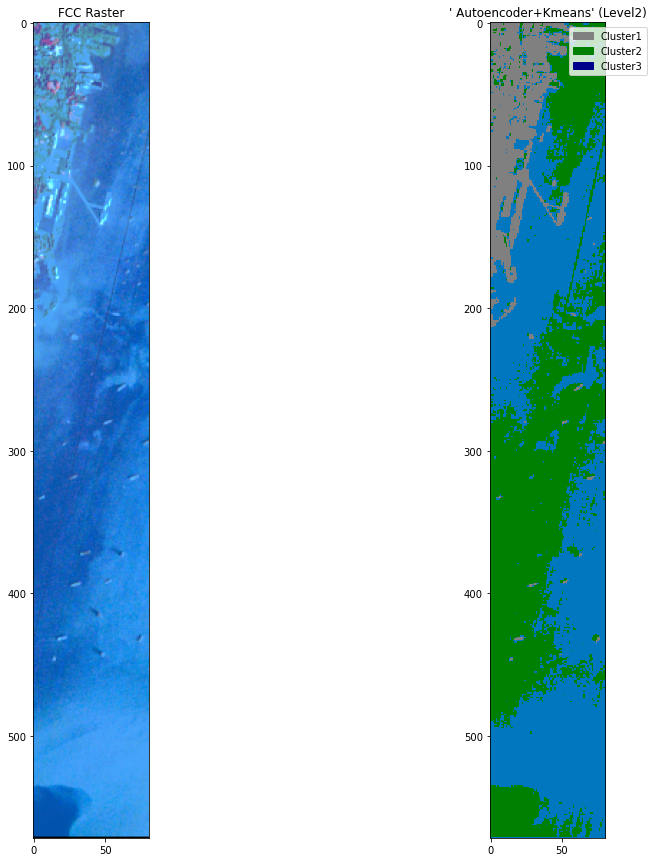

In [49]:

svdclustering.visualize_image(outputs_level2_autoencoder,rasterimage,"FCC Raster","' Autoencoder+Kmeans' (Level2)")

In [50]:
classcount=3
for i in range(1,classcount):
    class1_pixels=np.argwhere(outputs_level2_autoencoder==i)
    class_count=len(class1_pixels)
    print("No of pixels for cluster "+str(i+1)+" is "+str(class_count))

No of pixels for cluster 2 is 19255
No of pixels for cluster 3 is 21897


# Cumulative Results and Analysis

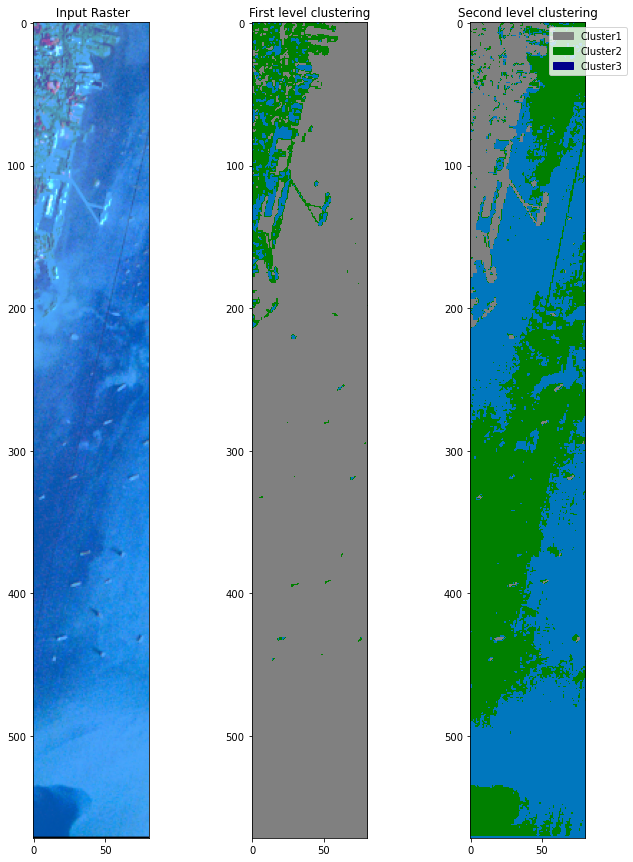

In [62]:
fig = plt.figure(figsize = (15,15))
columns = 4
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(rasterimage)
plt.title(' Input Raster')
fig.add_subplot(rows, columns, 2)
plt.imshow(labels_autoencoder_output,cmap=svdclustering.CMAP(labels_autoencoder_output))
plt.title('First level clustering')
fig.add_subplot(rows, columns, 3)
plt.imshow(outputs_level2_autoencoder,cmap=svdclustering.CMAP(outputs_level2_autoencoder))
plt.title('Second level clustering')
gray_patch = mpatches.Patch(color='Gray', label='Cluster1')
green_patch = mpatches.Patch(color='Green', label='Cluster2')
blue_patch = mpatches.Patch(color='Darkblue', label='Cluster3')
red_patch = mpatches.Patch(color='Red', label='Cluster4')
yellow_patch = mpatches.Patch(color='Yellow', label='Cluster5')
colorlist=[gray_patch,green_patch,blue_patch,red_patch,yellow_patch]
plt.legend(loc='upper right',handles=colorlist[0:3],bbox_to_anchor=(1.4, 1))
plt.show()

# Comparision of different feature reduction techniques

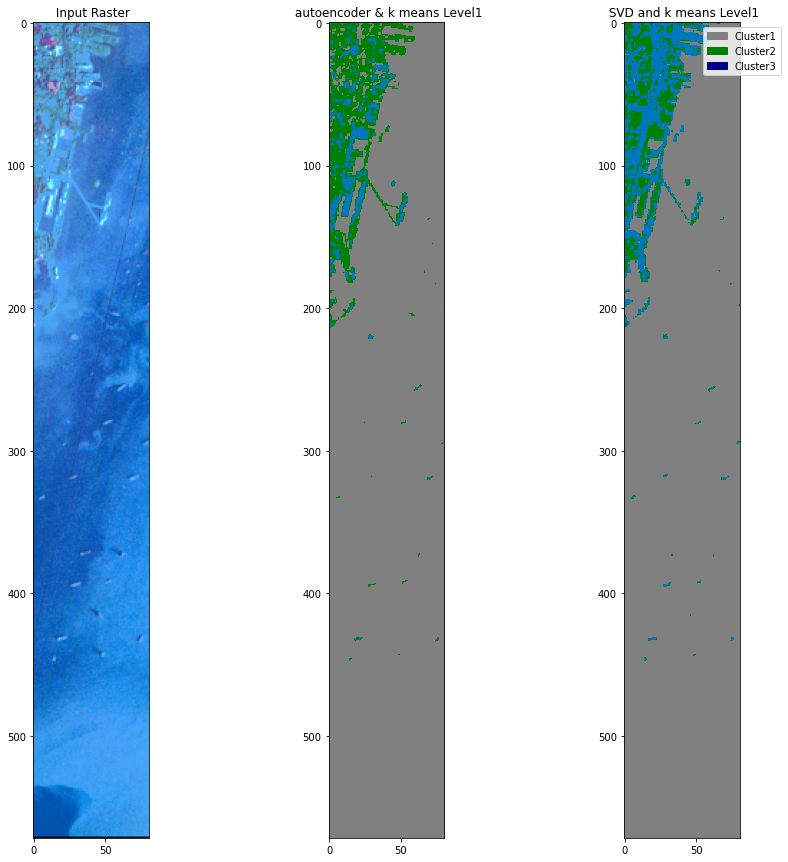

In [52]:
# level 1 features comparision
fig = plt.figure(figsize = (15,15))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(rasterimage)
plt.title(' Input Raster')
#svdkmeans_level1=labels_autoencoder_output
fig.add_subplot(rows, columns, 2)
plt.imshow(labels_autoencoder_output,cmap=svdclustering.CMAP(labels_autoencoder_output))
plt.title(' autoencoder & k means Level1')
#autoencoderkmeans_level1=labeloutput
fig.add_subplot(rows, columns, 3)
plt.imshow(labeloutput,cmap=svdclustering.CMAP(labeloutput))
plt.title(' SVD and k means Level1')
gray_patch = mpatches.Patch(color='Gray', label='Cluster1')
green_patch = mpatches.Patch(color='Green', label='Cluster2')
blue_patch = mpatches.Patch(color='Darkblue', label='Cluster3')
red_patch = mpatches.Patch(color='Red', label='Cluster4')
yellow_patch = mpatches.Patch(color='Yellow', label='Cluster5')
colorlist=[gray_patch,green_patch,blue_patch,red_patch,yellow_patch]
plt.legend(loc='upper right',handles=colorlist[0:3],bbox_to_anchor=(1.4, 1))
plt.show()

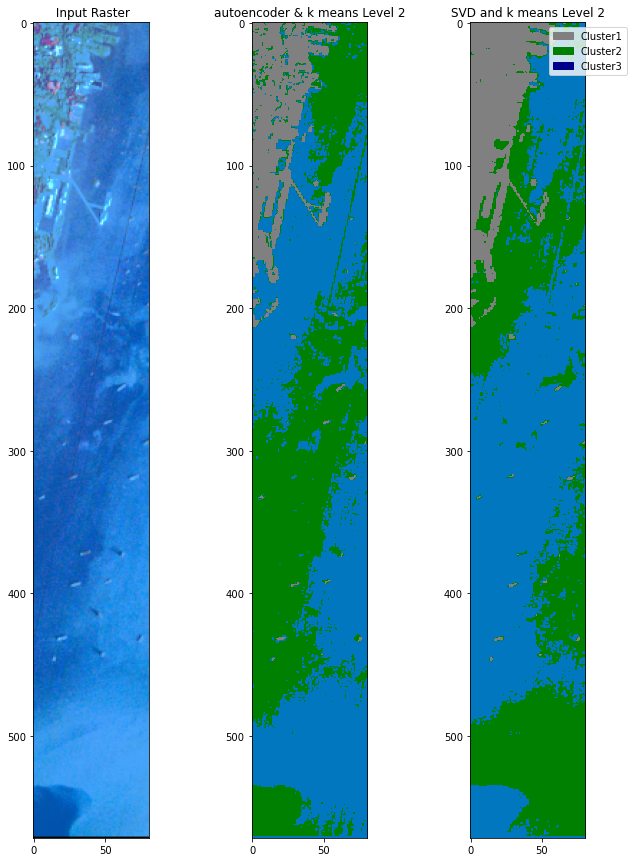

In [53]:
# level 2 features comparision
fig = plt.figure(figsize = (15,15))
columns = 4
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(rasterimage)
plt.title(' Input Raster')
level2_labelimage=outputs_level2_autoencoder
fig.add_subplot(rows, columns, 2)
plt.imshow(outputs_level2_autoencoder,cmap=svdclustering.CMAP(outputs_level2_autoencoder))
plt.title('autoencoder & k means Level 2')
level2_labelimage=labeloutput_secondlevel
fig.add_subplot(rows, columns, 3)
plt.imshow(labeloutput_secondlevel,cmap=svdclustering.CMAP(labeloutput_secondlevel))
plt.title('SVD and k means Level 2')
gray_patch = mpatches.Patch(color='Gray', label='Cluster1')
green_patch = mpatches.Patch(color='Green', label='Cluster2')
blue_patch = mpatches.Patch(color='Darkblue', label='Cluster3')
red_patch = mpatches.Patch(color='Red', label='Cluster4')
yellow_patch = mpatches.Patch(color='Yellow', label='Cluster5')
colorlist=[gray_patch,green_patch,blue_patch,red_patch,yellow_patch]
plt.legend(loc='upper right',handles=colorlist[0:3],bbox_to_anchor=(1.4, 1))
plt.show()

In [97]:
 with rasterio.open('stacked_raster.tif') as src:
        out_image, out_transform = rasterio.mask.mask(src,poly, crop=True)
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "count": 1,
                 "transform": out_transform,
                        "dtype":'float64'}
                                     )

In [98]:
with rasterio.open('subset1_svd_kmeans_level2.tif', "w", **out_meta) as dest:
    dest.write(labeloutput_secondlevel.reshape(1,572,81))